In [4]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.applications import VGG16,InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

In [5]:
print(tf.__version__)

2.4.1


 # **Loading Pretrained InceptionV3 model**

In [11]:
inception = InceptionV3(input_shape=(224,224,3),include_top=False,weights='imagenet')

In [8]:
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
print("Total Number of layers in vgg_model: ",len(inception.layers))

Total Number of layers in vgg_model:  311


In [13]:
# Setting all the layers as non trainable
for i in inception.layers:
  i.trainable=False

In [14]:
# Adding 2 more layers for Disease Prediction with 3 classes
x = Flatten()(inception.output)
prediction = Dense(3,activation='softmax')(x)

inception_model = Model(inputs=inception.input,outputs=prediction)

In [17]:
inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

In [18]:
# Change the Path to your system accordingly
TRAIN_PATH = "Data_3/Train/"
TEST_PATH = "Data_3/Test/"
VALID_PATH = "Data_3/Validation/"

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True
                                   )

test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_data = train_datagen.flow_from_directory(TRAIN_PATH,
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode='categorical')

test_data = test_datagen.flow_from_directory(TEST_PATH,
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode='categorical')

valid_data = valid_datagen.flow_from_directory(VALID_PATH,
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 513 images belonging to 3 classes.
Found 51 images belonging to 3 classes.
Found 21 images belonging to 3 classes.


In [38]:
test_data.class_indices

{'Covid-19': 0, 'Normal': 1, 'Pneumonia': 2}

In [22]:
# Model Compilation with "Adam" optimizer
inception_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
inception_model.fit(train_data,
              steps_per_epoch=len(train_data),
              epochs=30,
              validation_data=valid_data,
              validation_steps=len(valid_data))

In [ ]:
results = inception_model.evaluate(test_data)
print("Loss: ",results[0])
print("Accuracy: ",results[1])

## Plotting the confusion Matrix

In [135]:
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [126]:
test_data.class_indices

{'Covid-19': 0, 'Normal': 1, 'Pneumonia': 2}

In [129]:
y_true = []
y_test = []

for i in os.listdir("Data_3/Test/Covid-19/"):
    img = load_img("Data_3/Test/Covid-19/"+i, target_size=(224,224))
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)
    p = model.predict(img)
    p = np.argmax(p)
    y_test.append(p)
    y_true.append(0)

In [132]:
for i in os.listdir("Data_3/Test/Normal/"):
    img = load_img("Data_3/Test/Normal/"+i, target_size=(224,224))
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)
    p = model.predict(img)
    p = np.argmax(p)
    y_test.append(p)
    y_true.append(1)

In [133]:
    for i in os.listdir("Data_3/Test/Pneumonia/"):
        img = load_img("Data_3/Test/Pneumonia/"+i, target_size=(224,224))
        img = img_to_array(img)
        img = img/255
        img = np.expand_dims(img, axis=0)
        p = model.predict(img)
        p = np.argmax(p)
        y_test.append(p)
        y_true.append(2)

In [134]:
Confusion_Matrix = confusion_matrix(y_true,y_test)

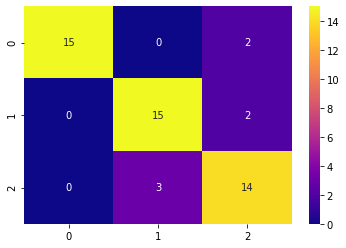

In [136]:
sns.heatmap(Confusion_Matrix,cmap='plasma',annot=True)

## Prediction

In [137]:
# Function to preprocess the Image for predction
model = load_model("model_V3_3_class.h5")
def img_predict(path):
    img = load_img(path,target_size=(224,224))
    plt.imshow(img)
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    pred = model.predict(img)
    # pred[0][0] = round(pred[0][0], 4)
    # pred[0][1] = round(pred[0][1], 4)
    # pred[0][2] = round(pred[0][2], 4)
    print("\n")
    print("Covid-19 : ",pred[0][0]*100,"%")
    print("Normal   : ",pred[0][1]*100,"%")
    print("Pneumonia: ",pred[0][2]*100,"%")



Covid-19 :  1.1668449603050649e-15 %
Normal   :  1.3110085721945456e-30 %
Pneumonia:  100.0 %


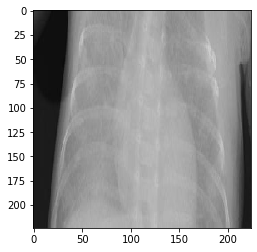

In [138]:
img_predict("Data_3/Test/Pneumonia/person1732_bacteria_4564.jpeg")

# -Thank You